## Example using constrained GP model
This is the code used to produce the 'robot arm' example in the paper _'Gaussian processes with linear operator inequality constraints'_, https://arxiv.org/abs/1901.03134

### Imports

In [1]:
### Basic imports ###
import sys, os

# For plotting
import plotly
import plotly.plotly as pltly
import plotly.graph_objs as go
import plotly.offline as pltlyoff
from IPython.display import display, HTML

# This is for plotting as static images (to show on e.g. GitHub)
import plotly.io as pio
from IPython.display import Image

# Numerics
import numpy as np
import scipy as sp
import itertools
import pyDOE
import pandas as pd

### Custom files ###

# Path to custom plotly module 'GPPlotly' for plotting 
# can be downloaded at https://github.com/cagrell/gp_plotly
dir_GPPlotly = 'C:\\Data\\git repos\\gp_plotly\\'
sys.path.append(dir_GPPlotly) 

# Path to the constrained GP moule 
# can be downloaded at https://github.com/cagrell/gp_constr
dir_gp_constr = 'C:\\Data\\git repos\\gp_constr\\'
sys.path.append(dir_gp_constr) 

# Import
from GPPlotly.plottingfunctions import PlotGP2d, add_traces_to_fig, gp_diagnostics, pred_vs_error_perc
from GPConstr.model import GPmodel, Constraint
from GPConstr.kern import kernel_Matern52

### Setup notebook ###
pltlyoff.init_notebook_mode(connected=True)
print('Python version', sys.version)

Loading constrained GP module from C:\Data\git repos\gp_constr
Loading R wrapper...
Running R from rpy2: R version 3.4.3 (2017-11-30)


Python version 3.6.3 (v3.6.3:2c5fed8, Oct  3 2017, 18:11:49) [MSC v.1900 64 bit (AMD64)]


#### Some helper functions for diagnostics

In [2]:
def get_diagnostics_df(x_test, y_test, mean, var):
    """ Put test data in a dataframe"""
    
    df = pd.DataFrame(x_test)
    df.columns = ['x' + str(i+1) for i in range(x_test.shape[1])]
    df['y_true'] = y_test
    df['y_mean'] = mean
    df['y_var'] = var
    
    return df

def fQ2(y_pred, y_test):
    """
    Compute Q2 = determination coefficient (R2) computed from a test sample (y_pred, y_test)
    """

    # Sum of squares of residuals
    SS_res = ((y_pred - y_test)**2).sum()

    # Total sum of squares
    y_test_avg = y_test.mean()
    SS_tot = ((y_test - y_test_avg)**2).sum()

    #Q2
    Q2 = 1 - SS_res/SS_tot

    return Q2

def fPVA(y_pred, y_pred_var, y_test):
    """
    Return Predictive Variance Adequation (PVA)
    """
    # Sum of sqares of scaled residuals
    SS_res_var = (((y_pred - y_test)**2)/(y_pred_var**2)).sum()

    PVA = np.abs(np.log((1/y_pred.shape[0])*SS_res_var))
    
    return PVA

## 1. Define function for generating synthetic test/training data


In [3]:
# Function to emulate/estimate
def robot_arm(x):
    """ 
    Returns (u, v), the end coordinates of the robot arm
    ** only defined for even dim input **
    """
    n = len(x)
    assert n % 2 == 0, 'only even number input for robot arm function'
    m = int(n/2)
    
    L = x[:m]
    theta = x[m:]*2*np.pi

    theta_sums = np.array([theta[:i+1].sum() for i in range(m)])
    u = np.dot(L, np.cos(theta_sums))
    v = np.dot(L, np.sin(theta_sums))
    
    return u, v

def fun(x):
    """ function motivated by robot arm function"""
    u, v = robot_arm(x)
    return u

def fun_mult(X):
    """ For multiple x in array X """
    return np.array([fun(X[i,:]) for i in range(X.shape[0])])

## 2. Emulation (no noise) in $\mathbb{R}^{4}$

### 2.1. Generate synthetic training data

In [4]:
# Design data - no noise
n_samples = 40
input_dim = 4

x_design = pyDOE.lhs(input_dim, samples = n_samples, criterion = 'maximin', iterations = 1000)
y_design = fun_mult(x_design)

### 2.2. Define GP model (without constraints)

In [5]:
# Set up model
ker = kernel_Matern52(variance = 1, lengthscale = [1]*input_dim)
model = GPmodel(kernel = ker, likelihood = 1E-6, mean = 0) # No Noise

# Training data
model.X_training = x_design
model.Y_training = y_design

In [6]:
# Optimize
model.optimize(include_constraint = False, fix_likelihood = True)
print(model)

..Running optimization for unconstrained GP ... DONE - Total time: 0.073 seconds
----- GP model ----- 
 mean = 0 
 likelihood = 1e-06 
 kernel: 
   type = Matern52 
   input dim = 4 
   lenghtscale = [1.34400972 0.89035128 0.18193652 0.27447109] 
   variance = 0.37431027793335486 
 constraint: 
   No constraints 
---------------------


#### Test the unconstrained model 

In [7]:
# Test data
n_test = 100
x_test = np.random.rand(n_test, input_dim) # Uniform samples
y_test = fun_mult(x_test)

# Run unconstrained model
mean_unconstr, var_unconstr = model.calc_posterior_unconstrained(x_test, full_cov = False)
mean_unconstr = np.array(mean_unconstr).flatten()
var_unconstr = np.array(var_unconstr).flatten()

# Collect data in df
df_unconstr = get_diagnostics_df(x_test, y_test, mean_unconstr, var_unconstr)


..Running calculation of K_w ... SKIP - (cached)
..Running calculation of Cholesky factor for K_w ... SKIP - (cached)
..Calculating f* | Y ... DONE - Total time: 0.002 seconds


In [8]:
# View first couple of records of dataframe with testing data
df_unconstr.head()

,x1,x2,x3,x4,y_true,y_mean,y_var
0,0.227566,0.072647,0.460207,0.111156,-0.285956,-0.598888,0.076119
1,0.753266,0.257437,0.779566,0.708566,-0.117593,-0.043665,0.053698
2,0.993209,0.215357,0.794228,0.113427,0.452579,0.241748,0.030502
3,0.149687,0.569095,0.679809,0.697908,-0.473118,-0.477841,0.037589
4,0.624637,0.771598,0.529788,0.716220,-0.594375,-0.432555,0.070534


In [9]:
# Print some summary statistics: Q^2, PVA and AWoCI
Q2, PVA = fQ2(df_unconstr['y_mean'], df_unconstr['y_true']), fPVA(df_unconstr['y_mean'], df_unconstr['y_var'], df_unconstr['y_true'])
AWoCI = 2*1.959963984540054*np.sqrt(df_unconstr['y_var']).mean()

print('....Summary statistics from {} predictions....'.format(n_test))
print('Q2 = {}, PVA = {}, AWoCI = {}'.format(Q2, PVA, AWoCI))

....Summary statistics from 100 predictions....
Q2 = 0.7134176285391497, PVA = 1.8935756854037618, AWoCI = 1.0709652434838082


In [10]:
# Plot diagnostics
figs = gp_diagnostics(df_unconstr, y_name = 'y', subplots = True)
for fig in figs:
    pltlyoff.iplot(fig, filename='')

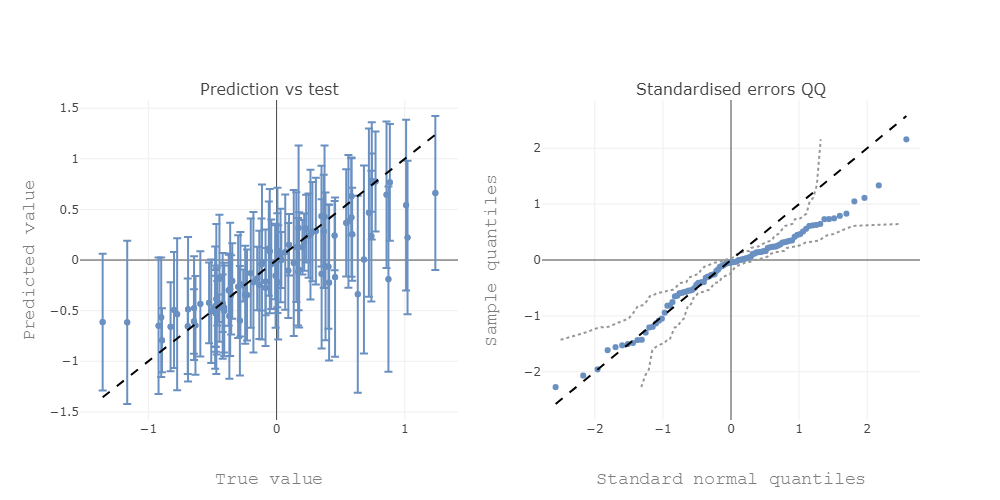

In [11]:
# Show plots as static image
Image(pio.to_image(figs[0], width=1000, height=500, scale=1, format='png'))

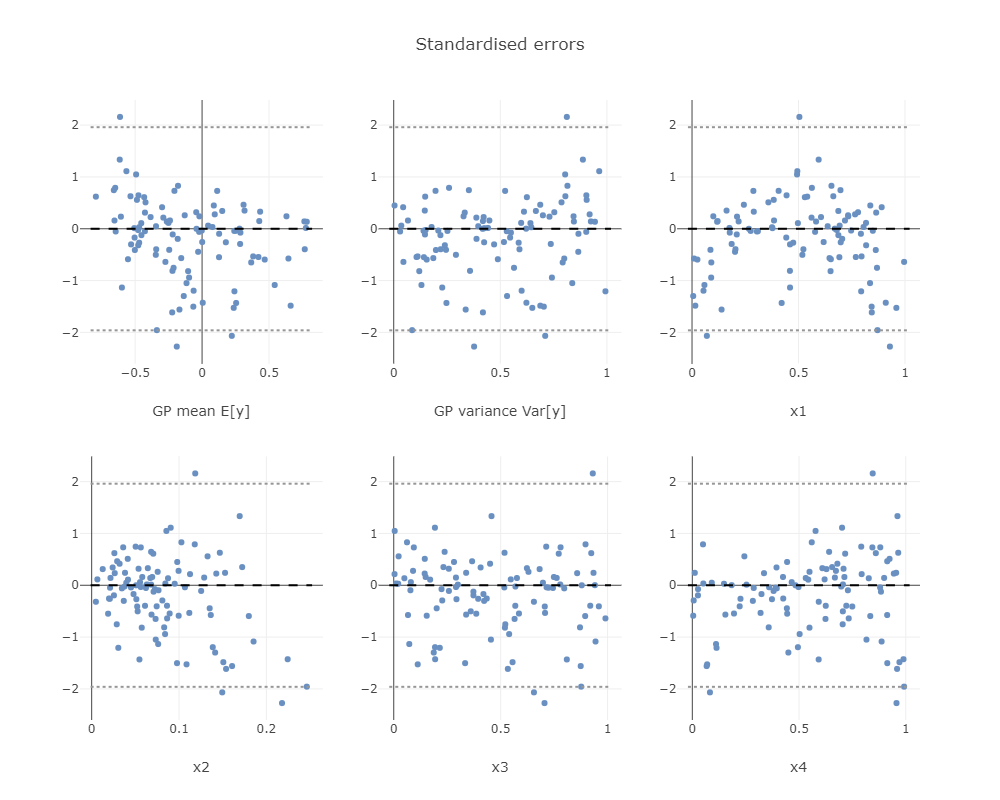

In [12]:
Image(pio.to_image(figs[1], width=1000, height=800, scale=1, format='png'))

#### Plot a 1D slice of the model

In [13]:
plot_x_dim = 1 # Dimension to plot
x_base_val = 0.5 # All other x has this value

# Test input
px_test = np.linspace(0, 1, 100)
px_test_arr = np.ones((len(px_test), input_dim))*x_base_val
px_test_arr[:,plot_x_dim] = px_test

# True function
y_true = fun_mult(px_test_arr)

# From GP
mean_unconstr, cov_unconstr = model.calc_posterior_unconstrained(px_test_arr, full_cov = True)
mean_unconstr = np.array(mean_unconstr).flatten()
var_unconstr = np.diagonal(cov_unconstr)

num_samples = 10
show_samplepaths = True
samplepaths_unconstr = []
if show_samplepaths: samplepaths_unconstr = np.random.multivariate_normal(mean_unconstr, cov_unconstr, num_samples).T

fig_unconstr_slice = PlotGP2d(x_mean = px_test, mean = mean_unconstr, var = var_unconstr,
                        x_true = px_test, y_true = y_true,
                        samplepaths = samplepaths_unconstr,
                        title = 'f(x) as a function of x[{0}] where x[i] = {1} for i != {0}'.format(plot_x_dim, x_base_val), xrange = [0, 1], smoothing = False)

pltlyoff.iplot(fig_unconstr_slice, filename='')

..Running calculation of K_w ... SKIP - (cached)
..Running calculation of Cholesky factor for K_w ... SKIP - (cached)
..Calculating f* | Y ... DONE - Total time: 0.004 seconds


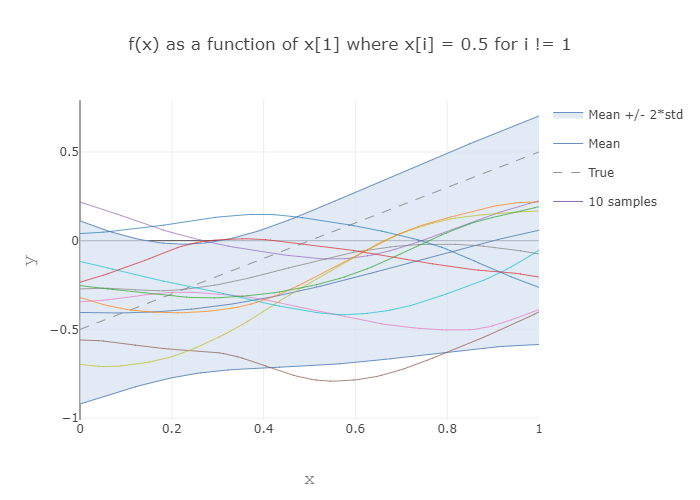

In [25]:
# Show plot as static image
Image(pio.to_image(fig_unconstr_slice, width=700, height=500, scale=1, format='png'))

### 2.2.3. Include the constraint that $\text{sgn}(\frac{\partial f}{\partial x_{i}})$ is known for $i = 1, 2$

In [14]:
# Helper functions for constraints

def fun_diff(x, i):
    """ return df/dx_i """
    eps = 0.001
    x2 = x.copy()
    x2[i] = x2[i] + eps
    f2 = fun(x2)
    f1 = fun(x)
    return (f2 - f1)/eps

def fun_diff_mult(X, i):
    """ For multiple x in array X """
    return np.array([fun_diff(X[j,:], i) for j in range(X.shape[0])])

def gen_diff_LB(i):
    def fun(x):
        y = fun_diff_mult(x, i)
        res = np.zeros(x.shape[0])
        res[y <= 0] = float('-inf')
        return res
    return fun

def gen_diff_UB(i):
    def fun(x):
        y = fun_diff_mult(x, i)
        res = np.zeros(x.shape[0])
        res[y >= 0] = float('inf')
        return res
    return fun


In [15]:
# Create derivative constraints
constr_dim = 2
constr_deriv = [Constraint(LB = gen_diff_LB(i), UB = gen_diff_UB(i)) for i in range(constr_dim)]

In [16]:
# Add constraints to model
model.constr_deriv = constr_deriv
model.constr_likelihood = 1E-6

In [17]:
# Find set of virtual observation locations
Omega = np.random.uniform(size = (1000, input_dim)) # Candidate set
df, num_pts, pc_min = model.find_XV_subop(p_target = 0.7, Omega = Omega, sampling_alg = 'minimax_tilting', num_samples = 1000,
                         max_iterations = 80, print_intermediate = False)

Searching for points XV s.t. P(a - nu < Lf < b + nu) > p_target = 0.7 for Lf = [df/dx_1, df/dx_2] and nu = 5.244005127080406e-07 ...
DONE - Found 80 points. Min. constraint prob = 0.3487855107680202. Total time spent = 1 minutes 24.2 seconds


In [26]:
# Print P(C|Y)
model.constrprob_Xv(n = 1000)

5.989726642064229e-42

#### Test the constrained model 

In [19]:
percentiles = [0.025, 0.5, 0.975]
mean, var, perc, mode, samples, times = model.calc_posterior_constrained(x_test, num_samples = 1000, save_samples = 30, algorithm = 'minimax_tilting', resample = False)
mean = np.array(mean).flatten()
lower = perc[0]
upper = perc[2]
var = np.array(var).flatten()

..Running calculation of K_w ... SKIP - (cached)
..Running calculation of Cholesky factor for K_w ... SKIP - (cached)
..Running preparation step 1 - dependence on (XS, X) ... DONE - time: 0.002 seconds
..Running preparation step 2 - dependence on (XV, X) ... SKIP - (cached)
..Running preparation step 3 - dependence on (XS, XV, X) ... DONE - time: 0.006 seconds
..sampling 1000 times from truncated constraint distribution C~|C, Y DONE - time: 0.968 seconds
..sampling 1000 times from constrained GP f*|C, Y DONE - time: 0.009 seconds
..computing statistics from samples DONE - time: 0.004 seconds
 DONE - Total time: 1.000 seconds


In [20]:
# Print some summary statistics: Q^2, PVA and AWoCI
Q2, PVA = fQ2(mean, y_test), fPVA(mean, var, y_test)
AWoCI = (upper - lower).mean()

print('....Summary statistics from {} predictions....'.format(n_test))
print('Q2 = {}, PVA = {}, AWoCI = {}'.format(Q2, PVA, AWoCI))

....Summary statistics from 100 predictions....
Q2 = 0.8290711367275898, PVA = 1.9486819632593868, AWoCI = 0.6046921738973541


In [21]:
fig = pred_vs_error_perc(mean, lower, upper, y_test, 95)
pltlyoff.iplot(fig, filename='')

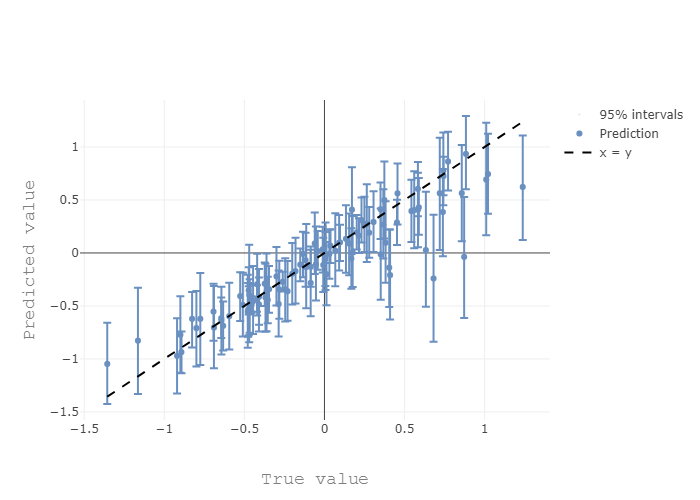

In [22]:
# Show plot as static image
Image(pio.to_image(fig, width=700, height=500, scale=1, format='png'))

#### Plot a 1D slice of the constrained model

In [23]:
# Plot constrained
mean, var, perc, mode, samples, times = model.calc_posterior_constrained(px_test_arr, compute_mode = False, num_samples = 1000, algorithm = 'minimax_tilting', resample = False)

p_lower = perc[0]
p_upper = perc[2]
p_label = '[p{}, p{}] conf.'.format(10, 90)

samplepaths_Z = []
if show_samplepaths: 
    samplepaths_Z = np.array(samples)

fig_constrained_1 = PlotGP2d(x_mean = px_test, mean = np.array(mean).flatten(),
                        samplepaths =  samplepaths_Z,
                        x_true = px_test, y_true = y_true,
                        p_lower = p_lower, p_upper = p_upper, p_label = p_label,
                        title = 'f(x) as a function of x[{0}] where x[i] = {1} for i != {0}'.format(plot_x_dim, x_base_val))

pltlyoff.iplot(fig_constrained_1, filename='')

..Running calculation of K_w ... SKIP - (cached)
..Running calculation of Cholesky factor for K_w ... SKIP - (cached)
..Running preparation step 1 - dependence on (XS, X) ... DONE - time: 0.011 seconds
..Running preparation step 2 - dependence on (XV, X) ... SKIP - (cached)
..Running preparation step 3 - dependence on (XS, XV, X) ... DONE - time: 0.008 seconds
..using old samples from truncated constraint distribution C~|C, Y
..sampling 1000 times from constrained GP f*|C, Y DONE - time: 0.025 seconds
..computing statistics from samples DONE - time: 0.004 seconds
 DONE - Total time: 0.062 seconds


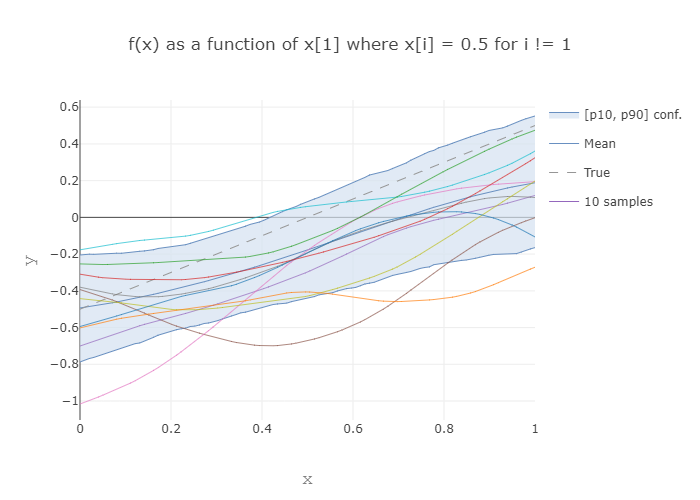

In [24]:
# Show plot as static image
Image(pio.to_image(fig_constrained_1, width=700, height=500, scale=1, format='png'))